In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import datetime
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
data = pd.read_csv('daily-website-visitors.csv')

In [154]:
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [155]:
data.isna().sum()

,0
Row,0
Day,0
Day.Of.Week,0
Date,0
Page.Loads,0
Unique.Visits,0
First.Time.Visits,0
Returning.Visits,0


# Data exploration

In [3]:
# Preprocess columns by converting numbers with commas to floats
data2=data.copy()
# Convert 'Date' column to datetime for easier plotting
data2['Date'] = pd.to_datetime(data2['Date'])
data2.set_index('Date', inplace=True)

In [4]:
data2.rename(columns = {'Day.Of.Week':'day_of_week'
                    ,'Page.Loads':'page_loads'
                    ,'Unique.Visits':'unique_visits'
                    ,'First.Time.Visits':'first_visits'
                    ,'Returning.Visits':'returning_visits'}, inplace = True)

data2=data2.replace(',','',regex=True)

data2['page_loads']=data2['page_loads'].astype(int)
data2['unique_visits']=data2['unique_visits'].astype(int)
data2['first_visits']=data2['first_visits'].astype(int)
data2['returning_visits']=data2['returning_visits'].astype(int)

In [159]:
data2.describe()

,Row,day_of_week,page_loads,unique_visits,first_visits,returning_visits
count,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000
mean,1084.000000,3.997231,4116.989386,2943.646516,2431.824181,511.822335
std,625.703338,2.000229,1350.977843,977.886472,828.704688,168.736370
min,1.000000,1.000000,1002.000000,667.000000,522.000000,133.000000
25%,542.500000,2.000000,3114.500000,2226.000000,1830.000000,388.500000
50%,1084.000000,4.000000,4106.000000,2914.000000,2400.000000,509.000000
75%,1625.500000,6.000000,5020.500000,3667.500000,3038.000000,626.500000
max,2167.000000,7.000000,7984.000000,5541.000000,4616.000000,1036.000000


In [160]:
data2['unique_visits']

,unique_visits
Date,
2014-09-14,1582
2014-09-15,2528
2014-09-16,2630
2014-09-17,2614
2014-09-18,2366
...,...
2020-08-15,1696
2020-08-16,2037
2020-08-17,2638


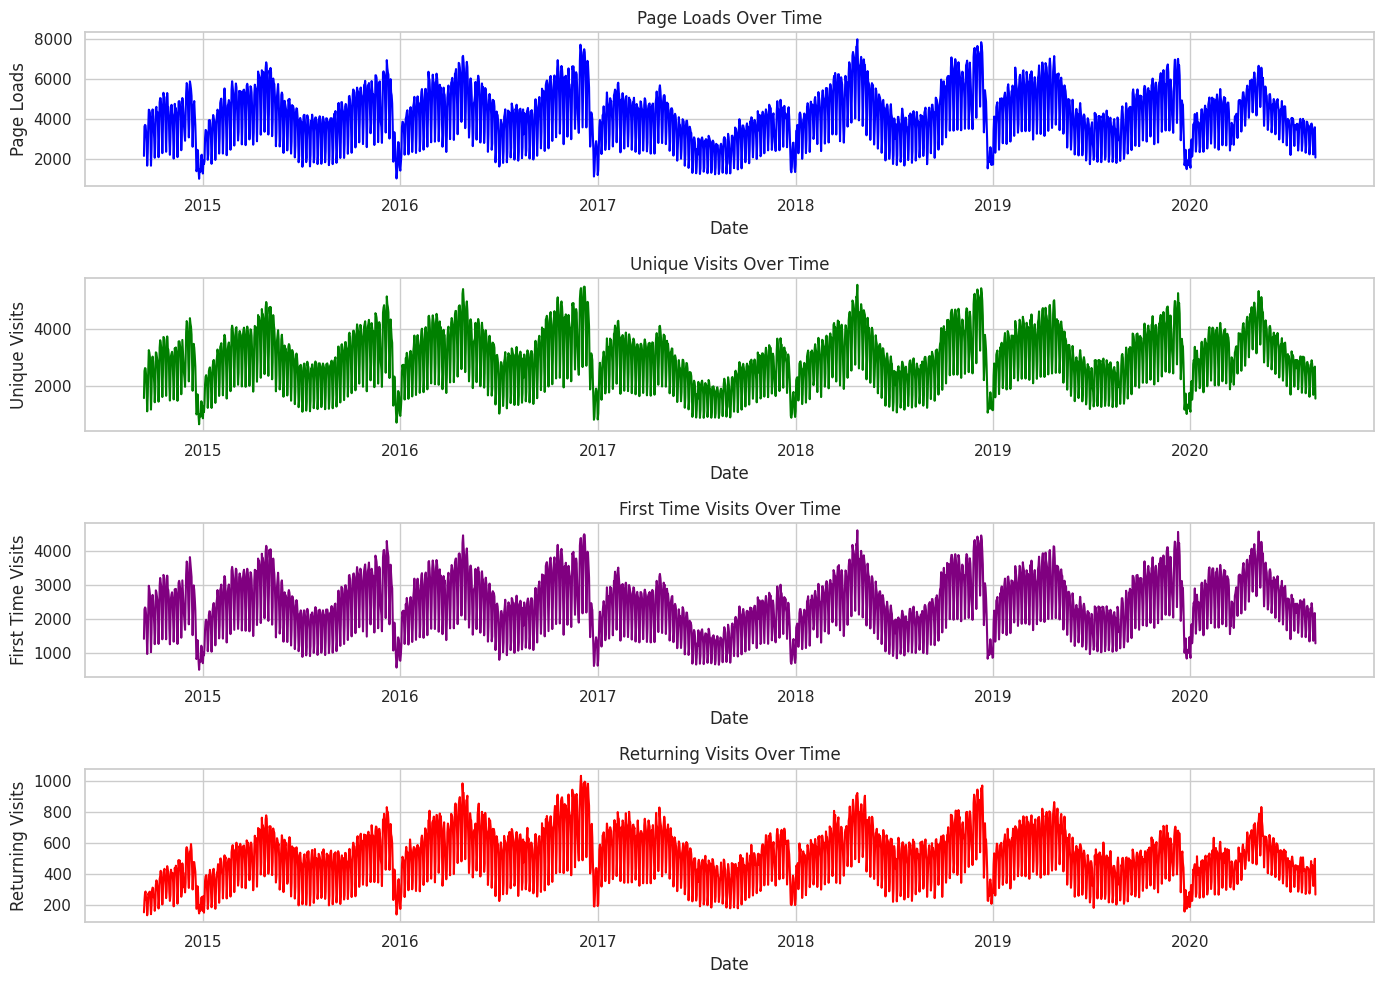

In [161]:
# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# Plot each column
plt.subplot(4, 1, 1)
plt.plot(data2.index, data2['page_loads'], label='Page Loads', color='blue')
plt.title("Page Loads Over Time")
plt.xlabel("Date")
plt.ylabel("Page Loads")

plt.subplot(4, 1, 2)
plt.plot(data2.index, data2['unique_visits'], label='Unique Visits', color='green')
plt.title("Unique Visits Over Time")
plt.xlabel("Date")
plt.ylabel("Unique Visits")

plt.subplot(4, 1, 3)
plt.plot(data2.index, data2['first_visits'], label='First Time Visits', color='purple')
plt.title("First Time Visits Over Time")
plt.xlabel("Date")
plt.ylabel("First Time Visits")

plt.subplot(4, 1, 4)
plt.plot(data2.index, data2['returning_visits'], label='Returning Visits', color='red')
plt.title("Returning Visits Over Time")
plt.xlabel("Date")
plt.ylabel("Returning Visits")

plt.tight_layout()
plt.show()


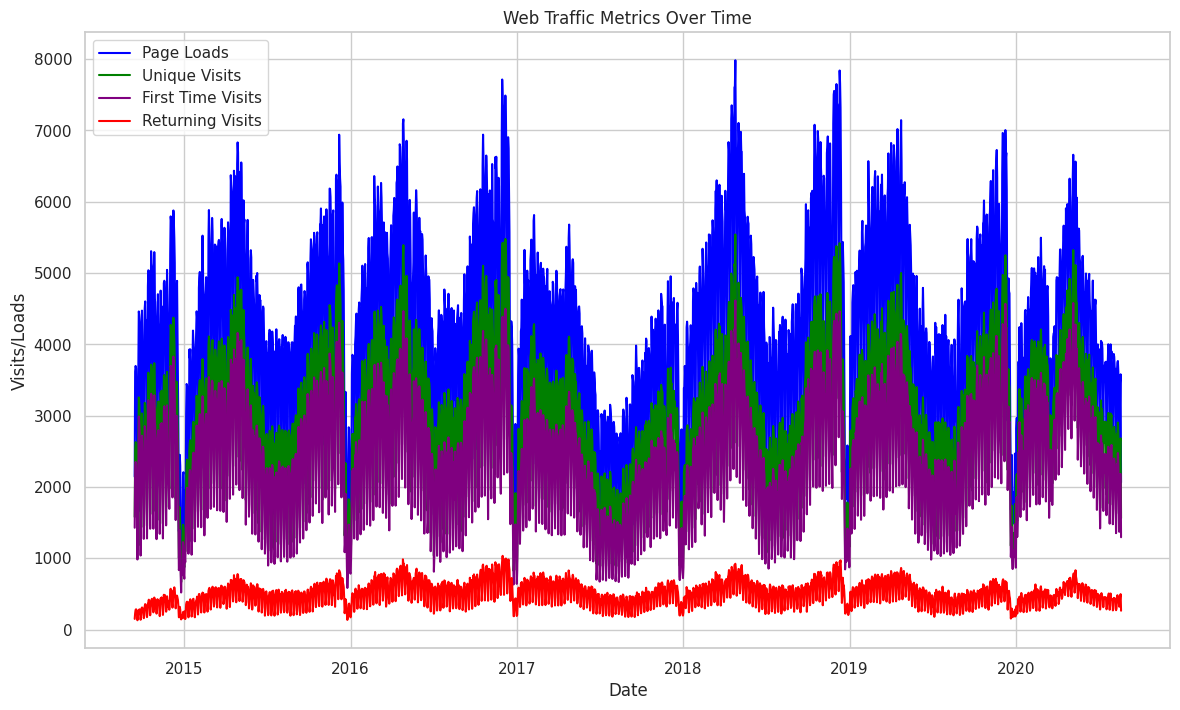

In [162]:
plt.figure(figsize=(14, 8))

plt.plot(data2.index, data2['page_loads'], label='Page Loads', color='blue')
plt.plot(data2.index, data2['unique_visits'], label='Unique Visits', color='green')
plt.plot(data2.index, data2['first_visits'], label='First Time Visits', color='purple')
plt.plot(data2.index, data2['returning_visits'], label='Returning Visits', color='red')

plt.title("Web Traffic Metrics Over Time")
plt.xlabel("Date")
plt.ylabel("Visits/Loads")
plt.legend(loc="upper left")
plt.show()


In [163]:
data_2014=data2[data2.index.year==2014]

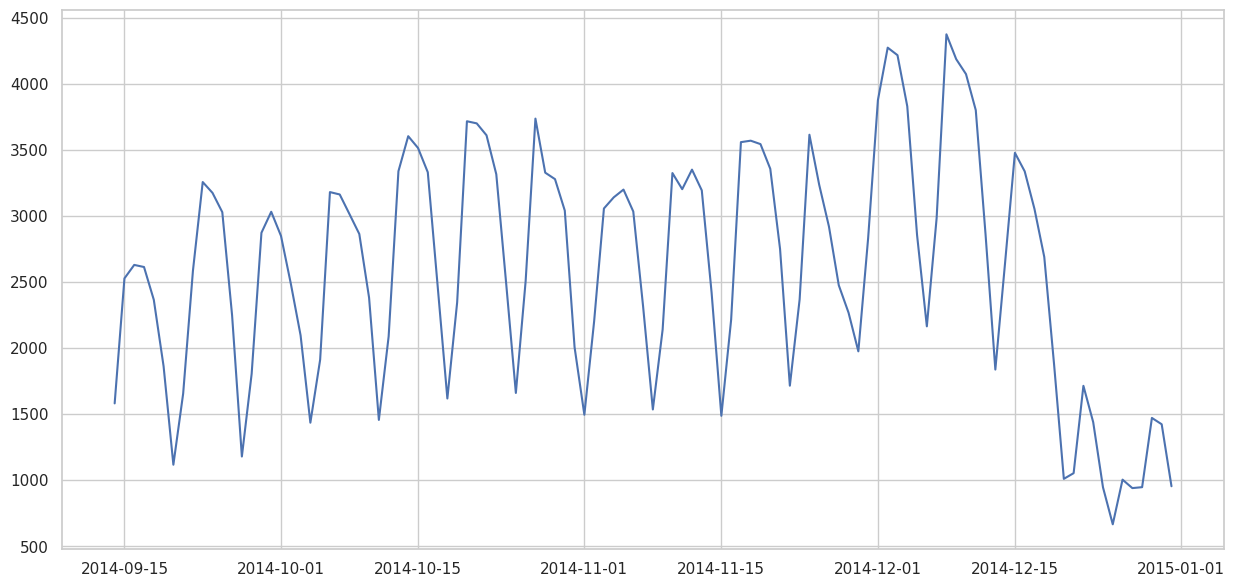

In [165]:
plt.figure(figsize=(15,7))
plt.plot(data_2014.index, data_2014['unique_visits'], label='Unique Visits')
plt.show()

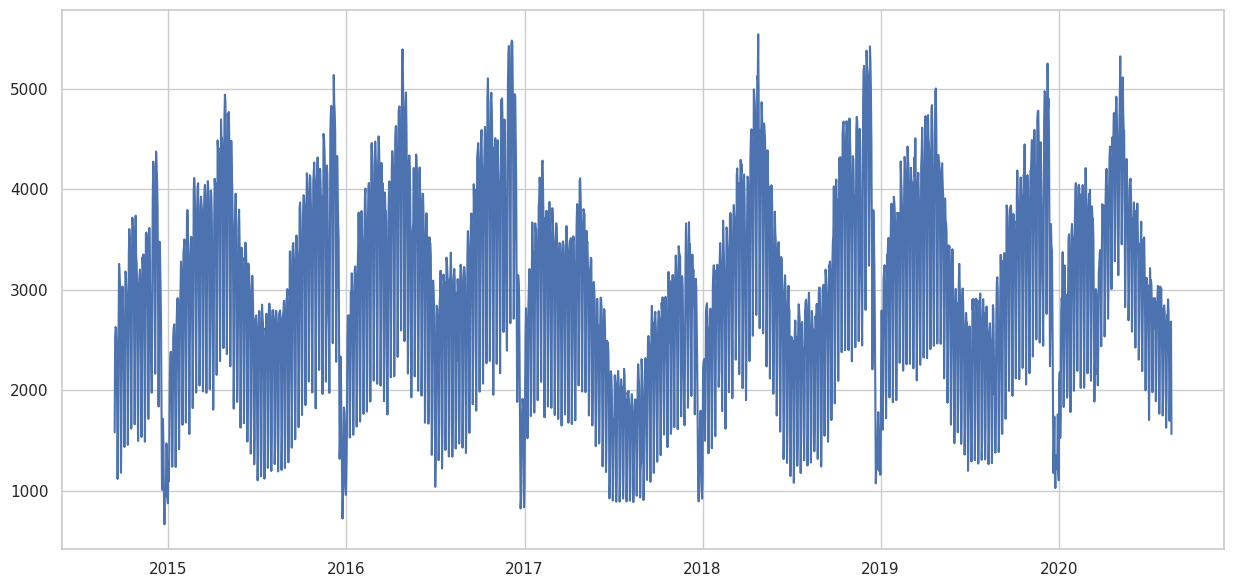

In [166]:
plt.figure(figsize=(15,7))
plt.plot(data2.index, data2['unique_visits'], label='Unique Visits')

# Data preprossing

In [5]:
#dropping featuers before training
data2=data2.drop('Day', axis=1)

In [6]:
data2.head()

,Row,day_of_week,page_loads,unique_visits,first_visits,returning_visits
Date,,,,,,
2014-09-14,1,1,2146,1582,1430,152
2014-09-15,2,2,3621,2528,2297,231
2014-09-16,3,3,3698,2630,2352,278
2014-09-17,4,4,3667,2614,2327,287
2014-09-18,5,5,3316,2366,2130,236


In [7]:
# Normalize all features
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data2)
data_normalized = pd.DataFrame(data_normalized, columns=data2.columns, index=data2.index)

In [8]:
# Create sequences
def create_sequences(data, target_column, sequence_length=7):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length].values
        target = data.iloc[i + sequence_length][target_column]
        sequences.append(sequence)
        targets.append(target)
    return torch.tensor(sequences).float(), torch.tensor(targets).float()

In [9]:
# Define target column and create sequences
target_column = 'unique_visits'
sequence_length = 30
X, y = create_sequences(data_normalized, target_column, sequence_length)

In [10]:
# Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model building

In [11]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architectures
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1, dropout=0.2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.batch_norm(out[:, -1, :])  # Use last timestep output
        out = self.dropout(out)
        out = self.fc(out)
        return out


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.batch_norm(out[:, -1, :])  # Use last timestep output
        out = self.dropout(out)
        out = self.fc(out)
        return out


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.batch_norm(out[:, -1, :])  # Use last timestep output
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [12]:
# Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.001, model_name="best_model.pth"):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Move data to device
        inputs = torch.tensor(X_train).float().to(device)
        targets = torch.tensor(y_train).float().to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(X_test).float().to(device)
            val_targets = torch.tensor(y_test).float().to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs.squeeze(), val_targets)
            val_losses.append(val_loss.item())

        # Save the model if validation loss improves
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            torch.save(model.state_dict(), model_name)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return model, train_losses, val_losses

# Hyperparameters
input_size = X_train.shape[2]  # Set input size to the number of features
hidden_size = 128
output_size = 1
epochs = 100
learning_rate = 0.001

# Initialize models
rnn_model = RNNModel(input_size, hidden_size, output_size)
lstm_model = LSTMModel(input_size, hidden_size, output_size)
gru_model = GRUModel(input_size, hidden_size, output_size)

# Train each model and save the best model
print("Training RNN model...")
rnn_model, rnn_train_loss, rnn_val_loss = train_model(rnn_model, X_train, y_train, X_test, y_test, epochs, learning_rate, "best_rnn_model.pth")

print("\nTraining LSTM model...")
lstm_model, lstm_train_loss, lstm_val_loss = train_model(lstm_model, X_train, y_train, X_test, y_test, epochs, learning_rate, "best_lstm_model.pth")

print("\nTraining GRU model...")
gru_model, gru_train_loss, gru_val_loss = train_model(gru_model, X_train, y_train, X_test, y_test, epochs, learning_rate, "best_gru_model.pth")


Training RNN model...
Epoch [10/100], Train Loss: 0.2105, Val Loss: 0.1615
Epoch [20/100], Train Loss: 0.1806, Val Loss: 0.1284
Epoch [30/100], Train Loss: 0.1375, Val Loss: 0.0886
Epoch [40/100], Train Loss: 0.1074, Val Loss: 0.0498
Epoch [50/100], Train Loss: 0.1002, Val Loss: 0.0535
Epoch [60/100], Train Loss: 0.0823, Val Loss: 0.0338
Epoch [70/100], Train Loss: 0.0781, Val Loss: 0.0055
Epoch [80/100], Train Loss: 0.0629, Val Loss: 0.0047
Epoch [90/100], Train Loss: 0.0617, Val Loss: 0.0045
Epoch [100/100], Train Loss: 0.0566, Val Loss: 0.0043

Training LSTM model...
Epoch [10/100], Train Loss: 0.2685, Val Loss: 0.1933
Epoch [20/100], Train Loss: 0.1964, Val Loss: 0.1642
Epoch [30/100], Train Loss: 0.1544, Val Loss: 0.1170
Epoch [40/100], Train Loss: 0.1252, Val Loss: 0.0985
Epoch [50/100], Train Loss: 0.0970, Val Loss: 0.0660
Epoch [60/100], Train Loss: 0.0885, Val Loss: 0.0509
Epoch [70/100], Train Loss: 0.0728, Val Loss: 0.0329
Epoch [80/100], Train Loss: 0.0669, Val Loss: 0.0240

# Model evaluation

RNN MSE: 0.0042
LSTM MSE: 0.0212
GRU MSE: 0.0056


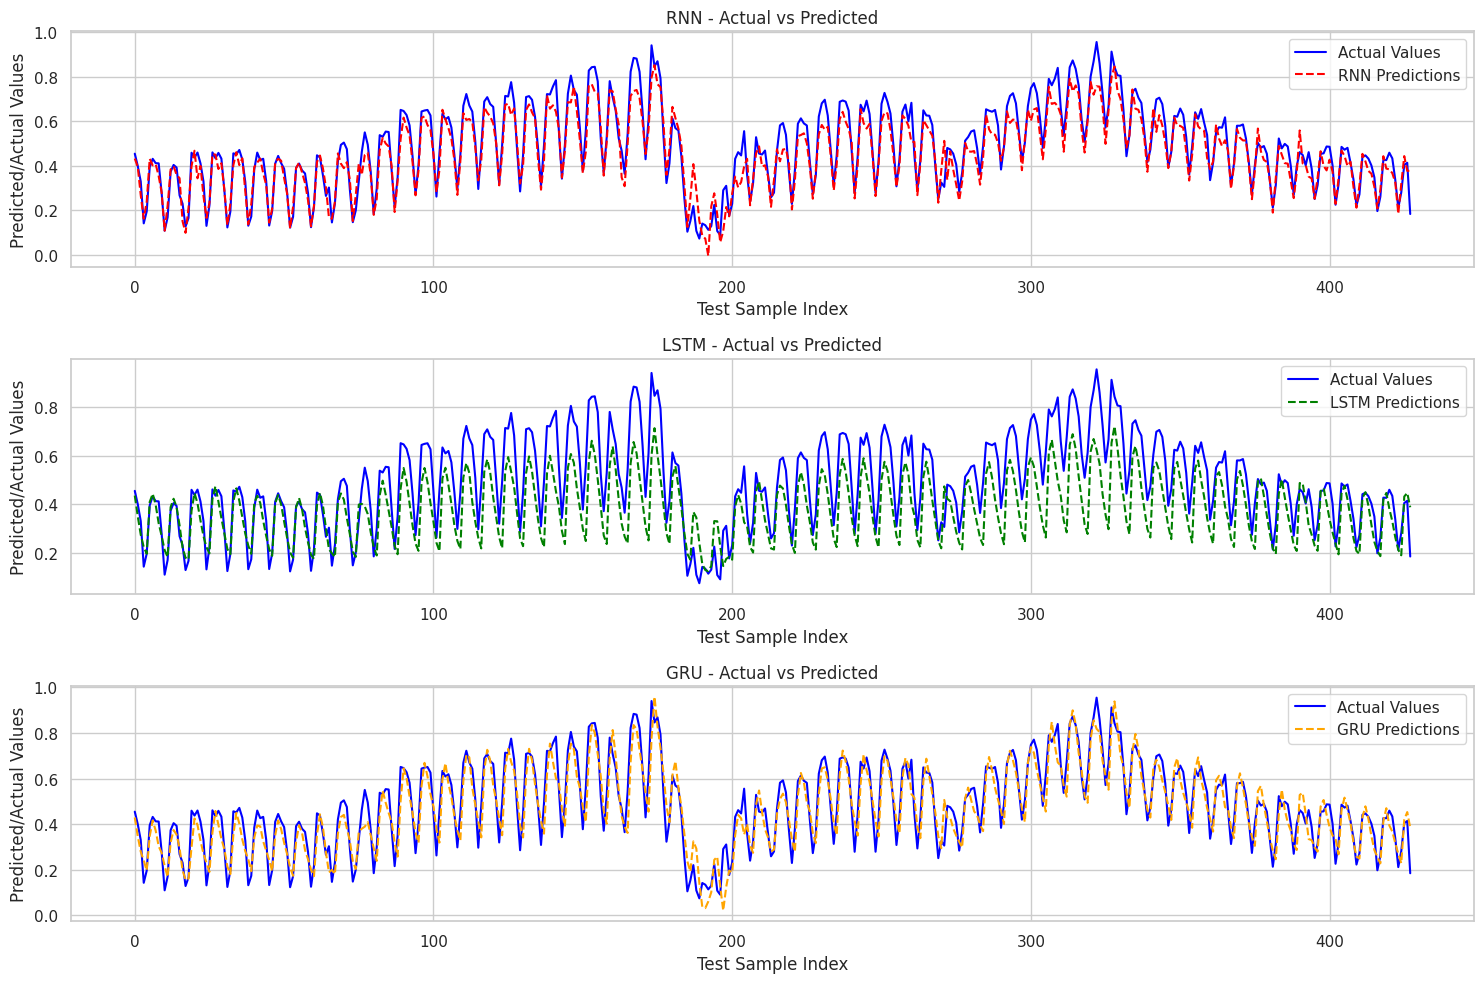

In [198]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    model.load_state_dict(torch.load(model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test).float().to(device)
        predictions = model(inputs).squeeze().cpu().numpy()
    mse = mean_squared_error(y_test, predictions)
    return mse, predictions

# Evaluate each model
rnn_mse, rnn_predictions = evaluate_model(rnn_model, X_test, y_test, "best_rnn_model.pth")
lstm_mse, lstm_predictions = evaluate_model(lstm_model, X_test, y_test, "best_lstm_model.pth")
gru_mse, gru_predictions = evaluate_model(gru_model, X_test, y_test, "best_gru_model.pth")

print(f"RNN MSE: {rnn_mse:.4f}")
print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"GRU MSE: {gru_mse:.4f}")

# Plotting the actual vs predicted values for each model
plt.figure(figsize=(15, 10))

# Plot RNN predictions vs actual values
plt.subplot(3, 1, 1)
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(rnn_predictions, label='RNN Predictions', color='red', linestyle='dashed')
plt.title('RNN - Actual vs Predicted')
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Values')
plt.legend()

# Plot LSTM predictions vs actual values
plt.subplot(3, 1, 2)
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(lstm_predictions, label='LSTM Predictions', color='green', linestyle='dashed')
plt.title('LSTM - Actual vs Predicted')
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Values')
plt.legend()

# Plot GRU predictions vs actual values
plt.subplot(3, 1, 3)
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(gru_predictions, label='GRU Predictions', color='orange', linestyle='dashed')
plt.title('GRU - Actual vs Predicted')
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Values')
plt.legend()

plt.tight_layout()
plt.show()


as we can see our best performing model is RNN

# Forcasting web traiffic the next week

Inverse Forecasted Unique Visits for the next week: [2506.224684   3696.98068881 2010.68845963 1618.51198095 1599.45476139
 1481.87077105 1714.29093415]


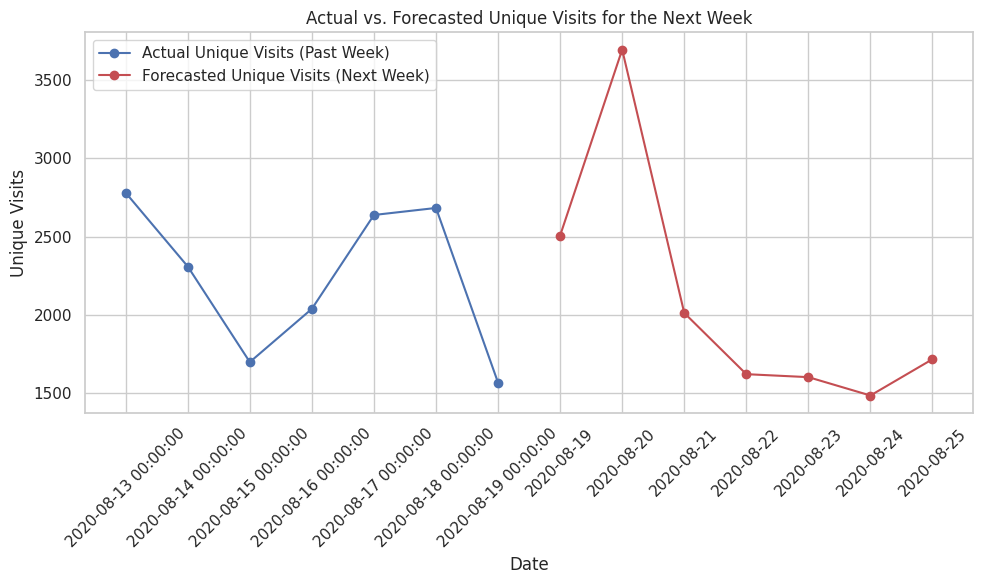

In [206]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Forecasting function
def forecast_next_week(model, last_week_data, days=7):
    model.eval()
    predictions = []

    # Ensure the last week data has the correct shape (batch_size, sequence_length, input_size)
    input_seq = torch.tensor(last_week_data).float().unsqueeze(0).to(device)  # Add batch dimension (1, 7, 6)

    with torch.no_grad():
        for _ in range(days):
            # Predict for the next day (only one output for unique_visits)
            next_day_pred = model(input_seq).squeeze().item()  # Get the prediction for the next day
            predictions.append(next_day_pred)

            # Update the input sequence by removing the oldest day and appending the new prediction
            next_input = np.append(input_seq.cpu().numpy()[0, 1:], [[next_day_pred] * input_seq.shape[2]], axis=0)
            input_seq = torch.tensor(next_input).float().unsqueeze(0).to(device)  # Update with new sequence

    return predictions

# Inverse transform function (for just 'unique_visits' feature)
def inverse_min_max(scaled_values, scaler):
    # Create an array of the same shape as the original data with scaled values for all features
    # We will create a dummy array of 1s for the other features and only modify 'unique_visits' column
    dummy_input = np.ones((scaled_values.shape[0], scaler.scale_.shape[0]))  # Create a dummy array (7, 6)
    dummy_input[:, 3] = scaled_values  # Assuming 'unique_visits' is at index 3 (4th column)

    # Now inverse transform the array that has 'unique_visits' values to the original scale
    inverse_values = scaler.inverse_transform(dummy_input)

    # Extract the 'unique_visits' column from the inverse-transformed array
    return inverse_values[:, 3]

# Assuming best_model is your trained LSTM or any model
best_model =  RNNModel(input_size=6, hidden_size=128, output_size=1).to(device)  # Set input_size=6 for all features
best_model.load_state_dict(torch.load("best_rnn_model.pth"))

# Use the last week of data from `X_train` or `X_test`
last_week_data = X_test[-1]  # Last sequence in the test set (should have shape (7, 6))

# Forecast the next 7 days
next_week_forecast = forecast_next_week(best_model, last_week_data)

# Inverse transform the forecasted unique_visits values (forecasted values are only for unique_visits)
forecasted_unique_visits = np.array(next_week_forecast)  # Convert list to numpy array

# Apply inverse transformation
inverse_forecasted = inverse_min_max(forecasted_unique_visits, scaler)

print("Inverse Forecasted Unique Visits for the next week:", inverse_forecasted)

# Now, we will plot the actual data (past week) and the forecasted data (next week)
# Ensure 'data2' has a column 'unique_visits' that you want to compare

# Get the actual data for the past 7 days
past_week_actual = data2['unique_visits'].tail(7).values  # Last 7 days of unique visits in data2

# Get the last date in 'data2'
last_date = data2.index[-1]

# Generate the next 7 days after the last date
forecast_dates = pd.date_range(start=last_date, periods=7, freq='D')  # Exclude the last date, start from the next day

# Assuming 'inverse_forecasted' holds your forecasted values after inverse transformation
forecasted_values = inverse_forecasted  # Adjust this variable as needed
# Plot the actual data (past week) and the forecasted data (next week)
# Plot the actual data (past week) and the forecasted data (next week) with different colors but connected
plt.figure(figsize=(10, 6))

# Plot the actual data (past week) in blue
plt.plot(range(len(past_week_actual)), past_week_actual, label='Actual Unique Visits (Past Week)', marker='o', color='b')

# Plot the forecasted data (next week) in red, continuing from where the actual data ends
plt.plot(range(len(past_week_actual), len(past_week_actual) + len(forecasted_values)), forecasted_values, label='Forecasted Unique Visits (Next Week)', marker='o', color='r')

# Update x-ticks with the last date and the next 7 forecast days
plt.xticks(range(len(past_week_actual) + len(forecasted_values)),
           list(data2['unique_visits'].tail(7).index) + forecast_dates.strftime('%Y-%m-%d').tolist(), rotation=45)

plt.title("Actual vs. Forecasted Unique Visits for the Next Week")
plt.xlabel("Date")
plt.ylabel("Unique Visits")
plt.legend()

plt.tight_layout()
plt.show()
